# How to train your DragoNN tutorial

**Tutorial length**: 25-30 minutes with a CPU.

## Outline
    * How to use this tutorial
    * Review of patterns in transcription factor binding sites
    * Learning to localize homotypic motif density
    * Sequence model definition
    * Training and interpretation of
        - single layer, single filter DragoNN
        - single layer, multiple filters DragoNN
        - Multi-layer DragoNN
        - Regularized multi-layer DragoNN
    * Critical questions in this tutorial:
        - What is the "right" way to get insight from a DragoNN model?
        - What are the limitations of different interpretation methods?
        - Do those limitations depend on the model and the target pattern?
    * Suggestions for further exploration

Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.


## How to use this tutorial

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./tutorial_images/inspecting_code.png)

We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [ ]:
%reload_ext autoreload
%autoreload 2
from dragonn.tutorial_utils import *
%matplotlib inline

![sequence properties 1](./tutorial_images/sequence_properties_1.jpg)
![sequence properties 2](./tutorial_images/sequence_properties_2.jpg)

# Learning to localize a homotypic motif density
In this tutorial we will learn how to localize a homotypic motif cluster. We will simulate a positive set of sequences with multiple instances of a motif in the center and a negative set of sequences with multiple motif instances positioned anywhere in the sequence:
![honotypic motif density localization](./tutorial_images/homotypic_motif_density_localization.jpg)
We will then train a binary classification model to classify the simulated sequences. To solve this task, the model will need to learn the motif pattern and whether instances of that pattern are present in the central part of the sequence.

We start by getting the simulation data.

## Getting simulation data

DragoNN provides a set of simulation functions. We will use the simulate_motif_density_localization function to simulate homotypic motif density localization. First, we obtain documentation for the simulation parameters.

In [3]:
print_simulation_info("simulate_motif_density_localization")



    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Next, we define parameters for a TAL1 motif density localization in 1500bp long sequence, with 0.4 GC fraction, and 2-4 instances of the motif in the central 150bp for the positive sequences. We simulate a total of 3000 positive and 3000 negative sequences.

In [4]:
motif_density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 3000,
    "num_neg": 3000,
    "GC_fraction": 0.4}

We get the simulation data by calling the get_simulation_data function with the simulation name and the simulation parameters as inputs. 1000 sequences are held out for a test set, 1000 sequences for a validation set, and the remaining 4000 sequences are in the training set.

In [5]:
simulation_data = get_simulation_data("simulate_motif_density_localization",
                                      motif_density_localization_simulation_parameters,
                                      validation_set_size=1000, test_set_size=1000)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the sequences:
![one hot encoding](./tutorial_images/one_hot_encoding.png)
Here are the first 10bp of a sequence in our training data:

In [6]:
simulation_data.X_train[0, :, :, :10]

array([[[0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 0, 1, 0]]], dtype=int8)

This matrix represent the 10bp sequence AAATGGGCCG.

# The homotypic motif density localization task
The goal of the model is to take the positive and negative sequences simulated above and classify them:
![classificatioin task](./tutorial_images/homotypic_motif_density_localization_task.jpg)

# DragoNN Models

A locally connected linear unit in a DragoNN model can represent a PSSM (part a). A sequence PSSM score is obtained by multiplying the PSSM across the sequence, thersholding the PSSM scores, and taking the max (part b). A PSSM score can also be computed by a DragoNN model with tiled locally connected linear units, amounting to a convolutional layer with a single convolutional filter representing the PSSM, followed by ReLU thersholding and maxpooling (part c).
![dragonn vs pssm](./tutorial_images/dragonn_and_pssm.jpg)
By utilizing multiple convolutional layers with multiple convolutional filters, DragoNN models can represent a wide range of sequence features in a compositional fashion:
![dragonn model figure](./tutorial_images/dragonn_model_figure.jpg)

# Getting a DragoNN model

The main DragoNN model class is SequenceDNN, which provides a simple interface to a range of models and methods to train, test, and interpret DragoNNs. SequenceDNN uses [keras](http://keras.io/), a deep learning library for [Theano](https://github.com/Theano/Theano) and [TensorFlow](https://github.com/tensorflow/tensorflow), which are popular software packages for deep learning.

To get a DragoNN model we:
    
    1) Define the DragoNN architecture parameters
        - obtain description of architecture parameters using the inspect_SequenceDNN() function
    2) Call the get_SequenceDNN function, which takes as input the DragoNN architecture parameters, and outputs a 
    randomly initialized DragoNN model.

To get a description of the architecture parameters we use the inspect_SequenceDNN function, which outputs documentation for the model class including the architecture parameters:

In [7]:
inspect_SequenceDNN()

Sequence DNN models.

Parameters
----------
seq_length : int, optional
    length of input sequence.
keras_model : instance of keras.models.Sequential, optional
    seq_length or keras_model must be specified.
num_tasks : int, optional
    number of tasks. Default: 1.
num_filters : list[int] | tuple[int]
    number of convolutional filters in each layer. Default: (15,).
conv_width : list[int] | tuple[int]
    width of each layer's convolutional filters. Default: (15,).
pool_width : int
    width of max pooling after the last layer. Default: 35.
L1 : float
    strength of L1 penalty.
dropout : float
    dropout probability in every convolutional layer. Default: 0.
verbose: int
    Verbosity level during training. Valida values: 0, 1, 2.

Returns
-------
Compiled DNN model.

Available methods:

deeplift
get_sequence_filters
in_silico_mutagenesis
plot_architecture
plot_deeplift
plot_in_silico_mutagenesis
predict
save
score
test
train


"Available methods" display what can be done with a SequenceDNN model. These include common operations such as training and testing the model, and more complex operations such as extracting insight from trained models. We define a simple DragoNN model with one convolutional layer with one convolutional filter, followed by maxpooling of width 35. 

In [8]:
one_filter_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [1],
    'conv_width': [10],
    'pool_width': 35}

we get a radnomly initialized DragoNN model by calling the get_SequenceDNN function with one_filter_dragonn_parameters as the input

In [ ]:
one_filter_dragonn = get_SequenceDNN(one_filter_dragonn_parameters)

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN not available)
/opt/conda/lib/python2.7/site-packages/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/opt/conda/lib/python2.7/site-packages/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/opt/conda/lib/python2.7/site-packages/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is 

## Training a DragoNN model

Next, we train the one_filter_dragonn by calling train_SequenceDNN with one_filter_dragonn and simulation_data as the inputs. In each epoch, the one_filter_dragonn will perform a complete pass over the training data, and update its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, the code prints performance metrics for the one_filter_dragonn on the validation data. Training stops once the loss on the validation stops improving for multiple consecutive epochs. The performance metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [ ]:
train_SequenceDNN(one_filter_dragonn, simulation_data)

A single layer, single filter model gets good performance and doesn't overfit much. Let's look at the learning curve to demonstrate this visually:

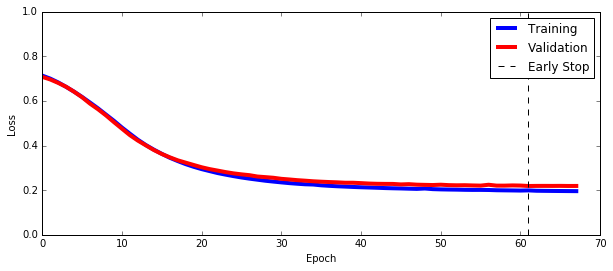

In [11]:
SequenceDNN_learning_curve(one_filter_dragonn)

# A multi-filter DragoNN model 
Next, we modify the model to have 15 convolutional filters instead of just one filter. How does this model compare to the single filter model?

In [ ]:
multi_filter_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15], ## notice the change from 1 filter to 15 filters
    'conv_width': [10],
    'pool_width': 35}
multi_filter_dragonn = get_SequenceDNN(multi_filter_dragonn_parameters)
train_SequenceDNN(multi_filter_dragonn, simulation_data)
SequenceDNN_learning_curve(multi_filter_dragonn)

It slightly outperforms the single filter model. Let's check if the learned filters capture the simulated pattern.

In [ ]:
interpret_SequenceDNN_filters(multi_filter_dragonn, simulation_data)

Only some of the filters closesly match the simulated pattern. This illustrates that interpreting model parameters directly works partially for multi-filter models. Another way to deduce learned patterns is to examine feature importances for specific examples. Next, we explore methods for feature importance scoring.

# Interpreting data with a DragoNN model

Using in-silico mutagenesis (ISM) and [DeepLIFT](https://arxiv.org/pdf/1605.01713v2.pdf), we can obtain scores for specific sequence indicating the importance of each position in the sequence. To assess these methods we compare ISM and DeepLIFT scores to motif scores for each simulated motif at each position in the sequence. These motif scores represent the "ground truth" importance of each position because they are based on the motifs used to simulate the data. We plot provide comaprisons for a positive class sequence on the left and a negative class sequence on the right.

In [ ]:
interpret_data_with_SequenceDNN(multi_filter_dragonn, simulation_data)

In the positive example (left side), ISM correctly highlights the two motif instances in the central 150bp. DeepLIFT highlights them as well. DeepLIFT also slightly highlights false positive feature on the left side but its score is sufficiently small that we can discriminate between the false positive feature and the true positive features. In the negative example (right side), ISM doesn't highlight anything but DeepLIFT a couple false positive feature almost as much as it highlights true positive features in the positive example.

# A multi-layer DragoNN model
Next, we train a 3 layer model for this task. Will it outperform the single layer model and to what extent will it overfit?

In [ ]:
multi_layer_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15, 15, 15], ## notice the change to multiple filter values, one for each layer
    'conv_width': [10, 10, 10], ## convolutional filter width has been modified to 25 from 45
    'pool_width': 35}

multi_layer_dragonn = get_SequenceDNN(multi_layer_dragonn_parameters)
train_SequenceDNN(multi_layer_dragonn, simulation_data)
SequenceDNN_learning_curve(multi_layer_dragonn)

This model performs about the same as the single layer model but it overfits more. We will try to address that with dropout regularization. But first, what do the first layer filters look like?

Plotting simulation motifs...


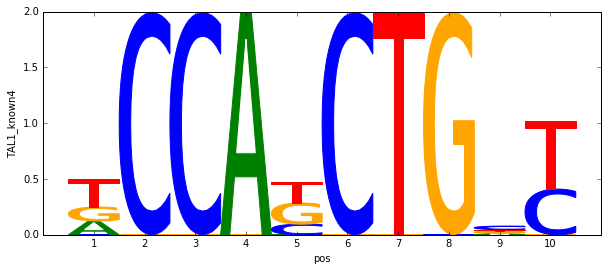

Visualizing convolutional sequence filters in SequenceDNN...


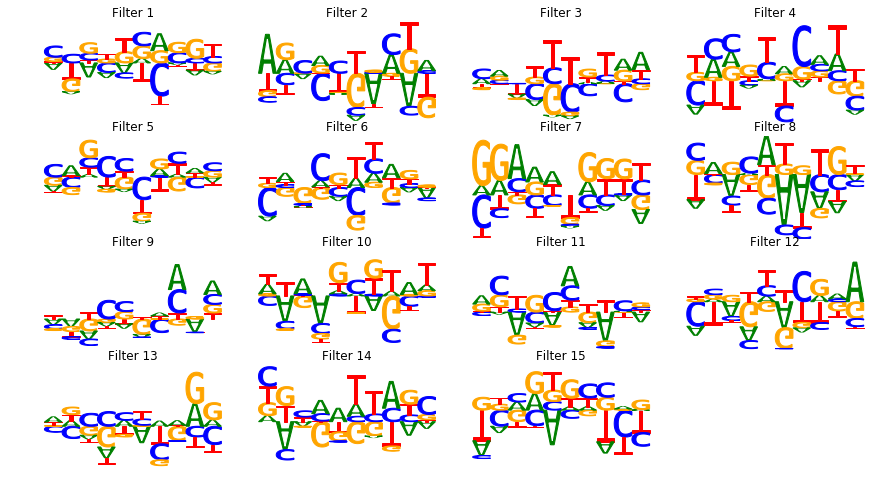

In [16]:
interpret_SequenceDNN_filters(multi_layer_dragonn, simulation_data)

The filters now make less sense than in the single layer model case. In multi-layered models, sequence features are learned compositionally across the layers. As a result, sequence filters in the first layer focus more on simple features that can be combined in higher layers to learn motif features more efficiently, and their interpretation becomes less clear based on simple visualizations. Let's see where ISM and DeepLIFT get us with this model.

In [ ]:
interpret_data_with_SequenceDNN(multi_layer_dragonn, simulation_data)

As in the single layer model case, ISM correctly highlights the two true positive features in the positive example (left side) and correctly ignores features in the negative example (right side). DeepLIFT still highlight the same false positive feature example in the positive example as before, but we can still separate it from the true positive features. In the negative example, it still highlights some false positive features.

# A regularized multi-layer DragoNN model
Next, we regularize the 3 layer using 0.2 dropout on every convolutional layer. Will dropout improve validation performance?

In [ ]:
regularized_multi_layer_dragonn_parameters = {
    'seq_length': 1000,
    'num_filters': [15, 15, 15],
    'conv_width': [10, 10, 10],
    'pool_width': 35,
    'dropout': 0.2} ## we introduce dropout of 0.2 on every convolutional layer for regularization
regularized_multi_layer_dragonn = get_SequenceDNN(regularized_multi_layer_dragonn_parameters)
train_SequenceDNN(regularized_multi_layer_dragonn, simulation_data)
SequenceDNN_learning_curve(regularized_multi_layer_dragonn)

As expected, dropout decreased the overfitting this model displayed previously and increased validation performance. Let's see the effect on feature discovery.

In [ ]:
interpret_data_with_SequenceDNN(regularized_multi_layer_dragonn, simulation_data)

ISM now highlights a false positive feature in the positive example (left side) more than the true positive features. What happened? A sufficiently accurate model should not change its confidence that there are 2 or more features in the central 150 base pairs (bps) due to a single bp change. So it makes sense that in the limit of the "perfect" model ISM will actually lose its power to discover features in this example.

How about DeepLIFT? DeepLIFT correctly highlights the only two positive features in the positive example. So it seems that in the limit of the "perfect" model, DeepLIFT gets closer to the true positive features.

Why did this happen? Why, as we regularize the model and improve the performance, ISM fails to highlight the true positive features? Here is a hint: in the limit of the "perfect" model for this simulation, will a single base pair perturbation to the positive example here change its confidence that it is still a positive example? I encourage you to open github issues on the dragonn repo to discuss these questions.

Below is an overview of patterns and simulations for further exploration.

# For further exploration 
In this tutorial we explored modeling of homotypic motif density. Other properties of regulatory DNA sequence include
![sequence properties 3](./tutorial_images/sequence_properties_3.jpg)
![sequence properties 4](./tutorial_images/sequence_properties_4.jpg)

DragoNN provides simulations that formulate learning these patterns into classification problems:
![sequence](./tutorial_images/sequence_simulations.png)

You can view the available simulation functions by running print_available_simulations:

In [ ]:
print_available_simulations()